Building an effective Point Spread Function (ePSF) for M67 FFI
==================================================

The ePSF
--------

The instrumental PSF is a combination of many factors that are
generally difficult to model.  `Anderson and King (2000; PASP 112,
1360) <http://adsabs.harvard.edu/abs/2000PASP..112.1360A>`_ showed
that accurate stellar photometry and astrometry can be derived by
modeling the net PSF, which they call the effective PSF (ePSF).  The
ePSF is an empirical model describing what fraction of a star's light
will land in a particular pixel.  The constructed ePSF is typically
oversampled with respect to the detector pixels.


Building an ePSF
----------------

Photutils provides tools for building an ePSF following the
prescription of `Anderson and King (2000; PASP 112, 1360)
<http://adsabs.harvard.edu/abs/2000PASP..112.1360A>`_ The process
involves iterating between the ePSF itself and the stars used to build
it.

To begin, we must first define a sample of stars used to build the
ePSF.  Ideally these stars should be bright (high S/N) and isolated to
prevent contamination from nearby stars.  One may use the star-finding
tools in Photutils (e.g.  :class:`~photutils.detection.DAOStarFinder`
or :class:`~photutils.detection.IRAFStarFinder`) to identify an
initial sample of stars.  However, the step of creating a good sample
of stars will also likely require visual inspection and manual
selection to ensure stars are sufficiently isolated and of good
quality (e.g. no cosmic rays, detector artifacts, etc.).

Let's start by loading a simulated HST/WFC3 image in the F160W band::

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.io import fits

In [6]:
hdu = fits.open('/Users/obsidian/Desktop/ktwo2017344214411-c16_ffi-cal.fits')

In [7]:
#data = hdu[4].data
data = hdu['MOD.OUT 15.4'].data

Trim the edges, use a subset of the image for simplicity.

In [8]:
dat = data[50:-50, 50:-50]
#dat = data[50:550, 50:550]

In [9]:
vlo, lo, medlo, med, hi, vhi = np.nanpercentile(data, (1,5,10,50,95,99))

In [10]:
vstep = (hi-lo)/300.0

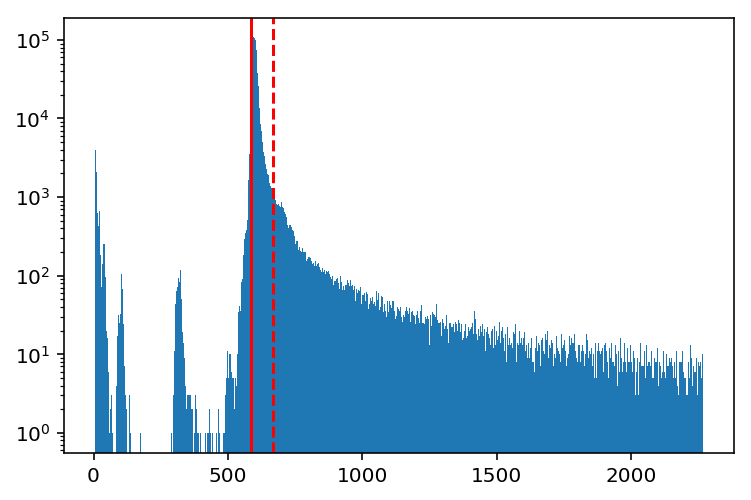

In [11]:
xbins = np.arange(lo, vhi, vstep)
plt.hist(data.reshape(-1), bins=xbins)
plt.axvline(medlo, c='red')
plt.axvline(hi, c='red', linestyle='dashed')
plt.yscale('log')

In [12]:
#plt.figure(figsize=(8,8))
#plt.imshow(data, vmin=vlo, vmax=hi)

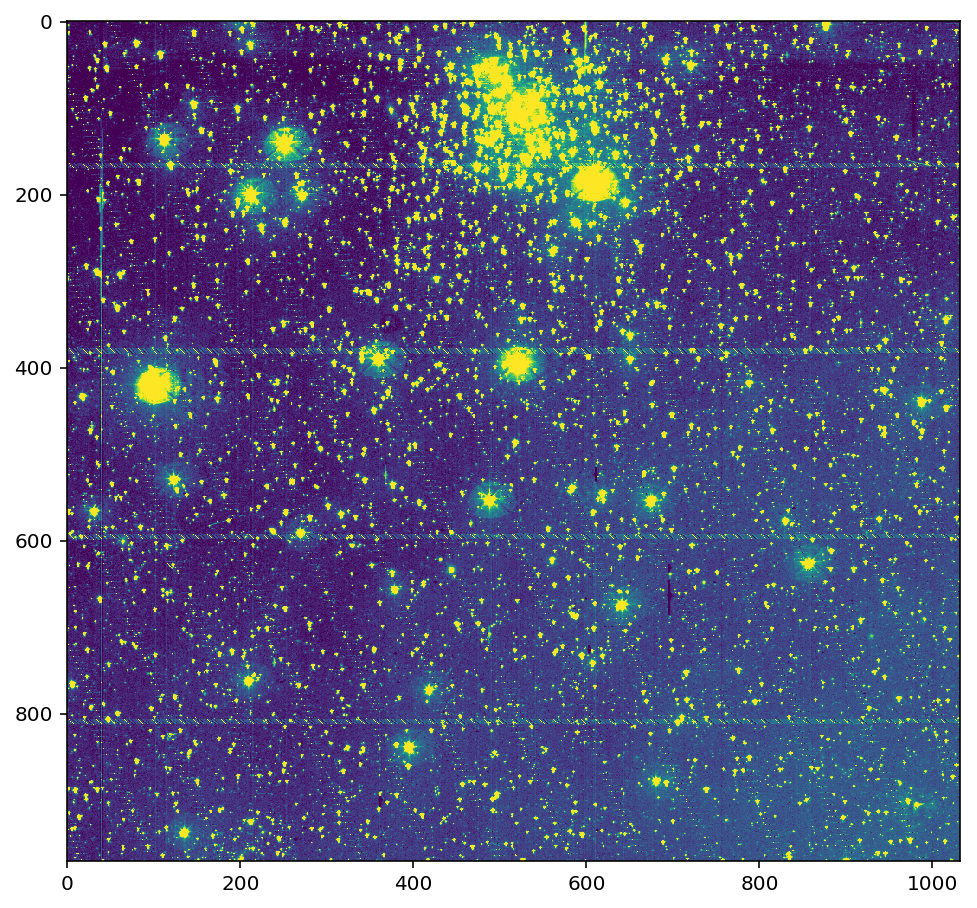

In [13]:
plt.figure(figsize=(8,8))

plt.imshow(dat, vmin=medlo, vmax=hi)

Dramatic PSF!

In [14]:
data = dat

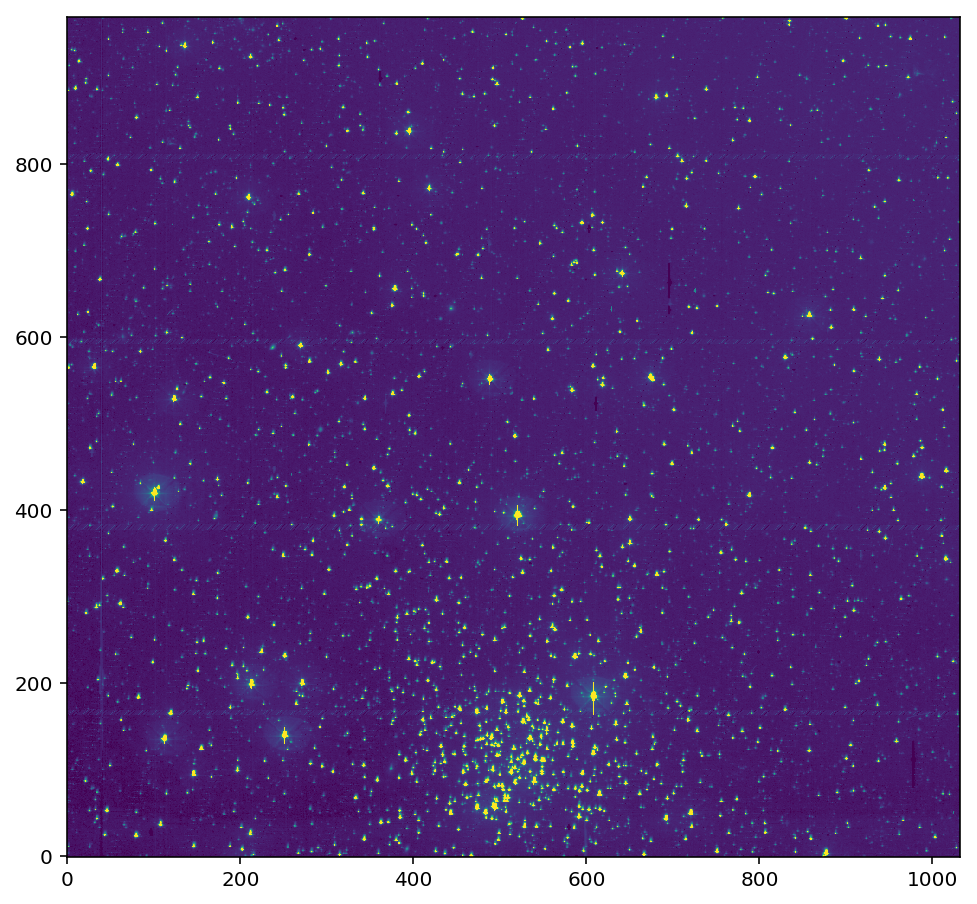

In [15]:
from astropy.visualization import simple_norm
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis');

For this example we'll use the :func:`~photutils.detection.find_peaks`
function to identify the stars and their initial positions.  We will
not use the centroiding option in
:func:`~photutils.detection.find_peaks` to simulate the effect of
having imperfect initial guesses for the positions of the stars.  Here we
set the detection threshold value to 500.0 to select only the brightest
stars:

In [16]:
from photutils import find_peaks
peaks_tbl = find_peaks(data, threshold=2000.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   716      0  3242.8508
   874      0  4873.7412
   457      1  3483.3228
   467      1  33940.133
   215      2  5036.9268
   314      2  30764.719
   666      2  37354.262
   436      3  20272.008
   877      3  176618.34
   267      4  7407.2603
   ...    ...        ...
   945    960  7306.6157
   834    961  10680.324
   110    962  3215.3499
   249    962  2025.5731
   365    962  2494.4021
   834    965  37541.133
   701    966  2044.4067
   416    968  2395.8208
   526    968  14273.825
   900    968  67714.242
   757    969  5645.2075
Length = 1552 rows


In [19]:
peaks_tbl['neighbor_dist'] = 9999

for i in range(1552):
    dist_arr = np.sqrt(( (peaks_tbl['x_peak'][i] - peaks_tbl['x_peak'].data)**2 +
                 (peaks_tbl['y_peak'][i] - peaks_tbl['y_peak'].data)**2 ))
    peaks_tbl['neighbor_dist'][i] = np.min(dist_arr[dist_arr > 0])

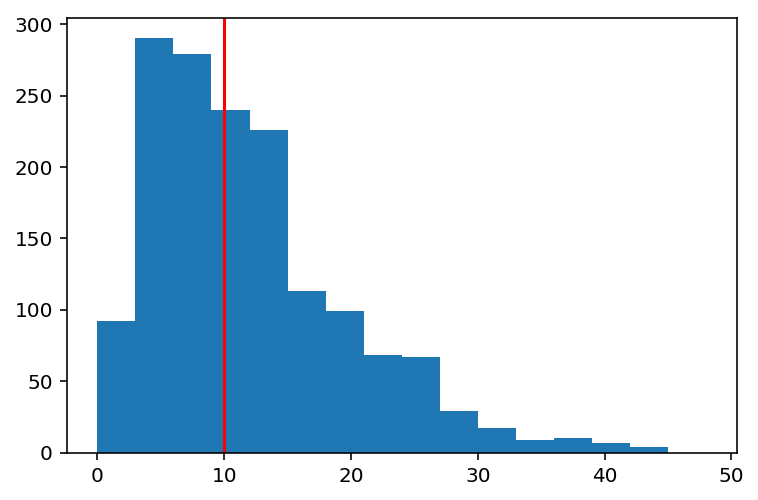

In [23]:
plt.hist(peaks_tbl['neighbor_dist'], bins=np.arange(0, 50, 3));
plt.axvline(10, c='red')
#plt.axvline(45, c='red', linestyle='dashed')
plt.yscale('linear')
gi_mask1 = (peaks_tbl['neighbor_dist'] > 15)

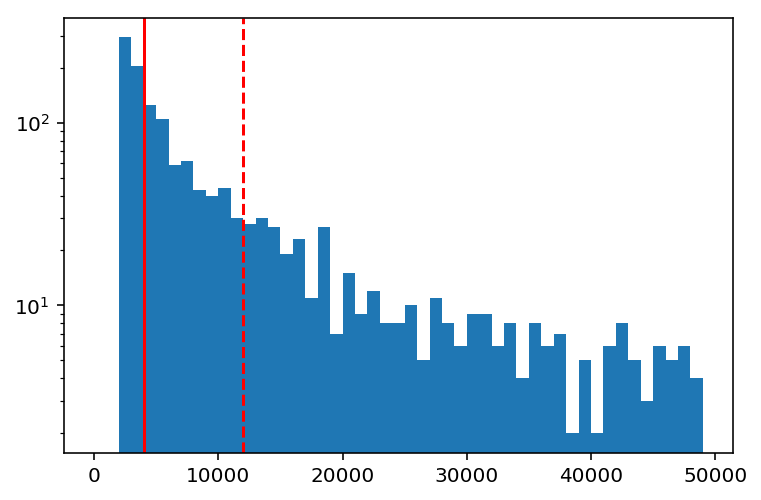

In [24]:
plt.hist(peaks_tbl['peak_value'], bins=np.arange(0, 50000, 1000));
plt.axvline(4000, c='red')
plt.axvline(12000, c='red', linestyle='dashed')
plt.yscale('log')
gi_mask2 = ( (peaks_tbl['peak_value'] < 12000) & (peaks_tbl['peak_value'] > 4000))

In [25]:
gi_mask = gi_mask1 & gi_mask2

Note that the stars are sufficiently separated in the simulated image
that we do not need to exclude any stars due to crowding.  In practice
this step will require some manual inspection and selection.

Next, we need to extract cutouts of the stars using the
:func:`~photutils.psf.extract_stars` function.  This function requires
a table of star positions either in pixel or sky coordinates.  For
this example we are using the pixel coordinates, which need to be in
table columns called simply ``x`` and ``y``.  Let's create that
table:

In [26]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak'][gi_mask]
stars_tbl['y'] = peaks_tbl['y_peak'][gi_mask]

The star cutouts from which we build the ePSF must have the background
subtracted.  Here we'll use the sigma-clipped median value as the
background level.  If the background in the image varies across the
image, one should use more sophisticated methods (e.g.
`~photutils.background.Background2D`).

Let's subtract the background from the image::

In [27]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,maxiters=None)
data -= median_val

The :func:`~photutils.psf.extract_stars` function requires the input
data as an `~astropy.nddata.NDData` object.  An
`~astropy.nddata.NDData` object is easy to create from our data
array::

In [28]:
from astropy.nddata import NDData
nddata = NDData(data=data)

We are now ready to create our star cutouts using the
:func:`~photutils.psf.extract_stars` function.  For this simple
example we are extracting stars from a single image using a single
catalog.  The :func:`~photutils.psf.extract_stars` can also extract
stars from multiple images using a separate catalog for each image or
a single catalog.  When using a single catalog, the star positions
must be in sky coordinates (as `~astropy.coordinates.SkyCoord`
objects) and the `~astropy.nddata.NDData` objects must contain valid
`~astropy.wcs.WCS` objects.  In the case of using multiple images
(i.e. dithered images) and a single catalog, the same physical star
will be "linked" across images, meaning it will be constrained to have
the same sky coordinate in each input image.

Let's extract 25 x 25 pixel cutouts of our selected stars:

In [38]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=11)

In [39]:
stars.n_good_stars, stars.n_stars

(137, 137)

They're all good stars.

The function returns a `~photutils.psf.Stars` object containing the
cutouts of our selected stars.  The function extracted 403 stars, from
which we'll build our ePSF.  Let's show the first 25 of them:

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Clean the identified stars:
- Stars that are too bright are saturated.
- Stars that are too faint are noisy.
- Stars with nearby neighbors are not isolated enough.

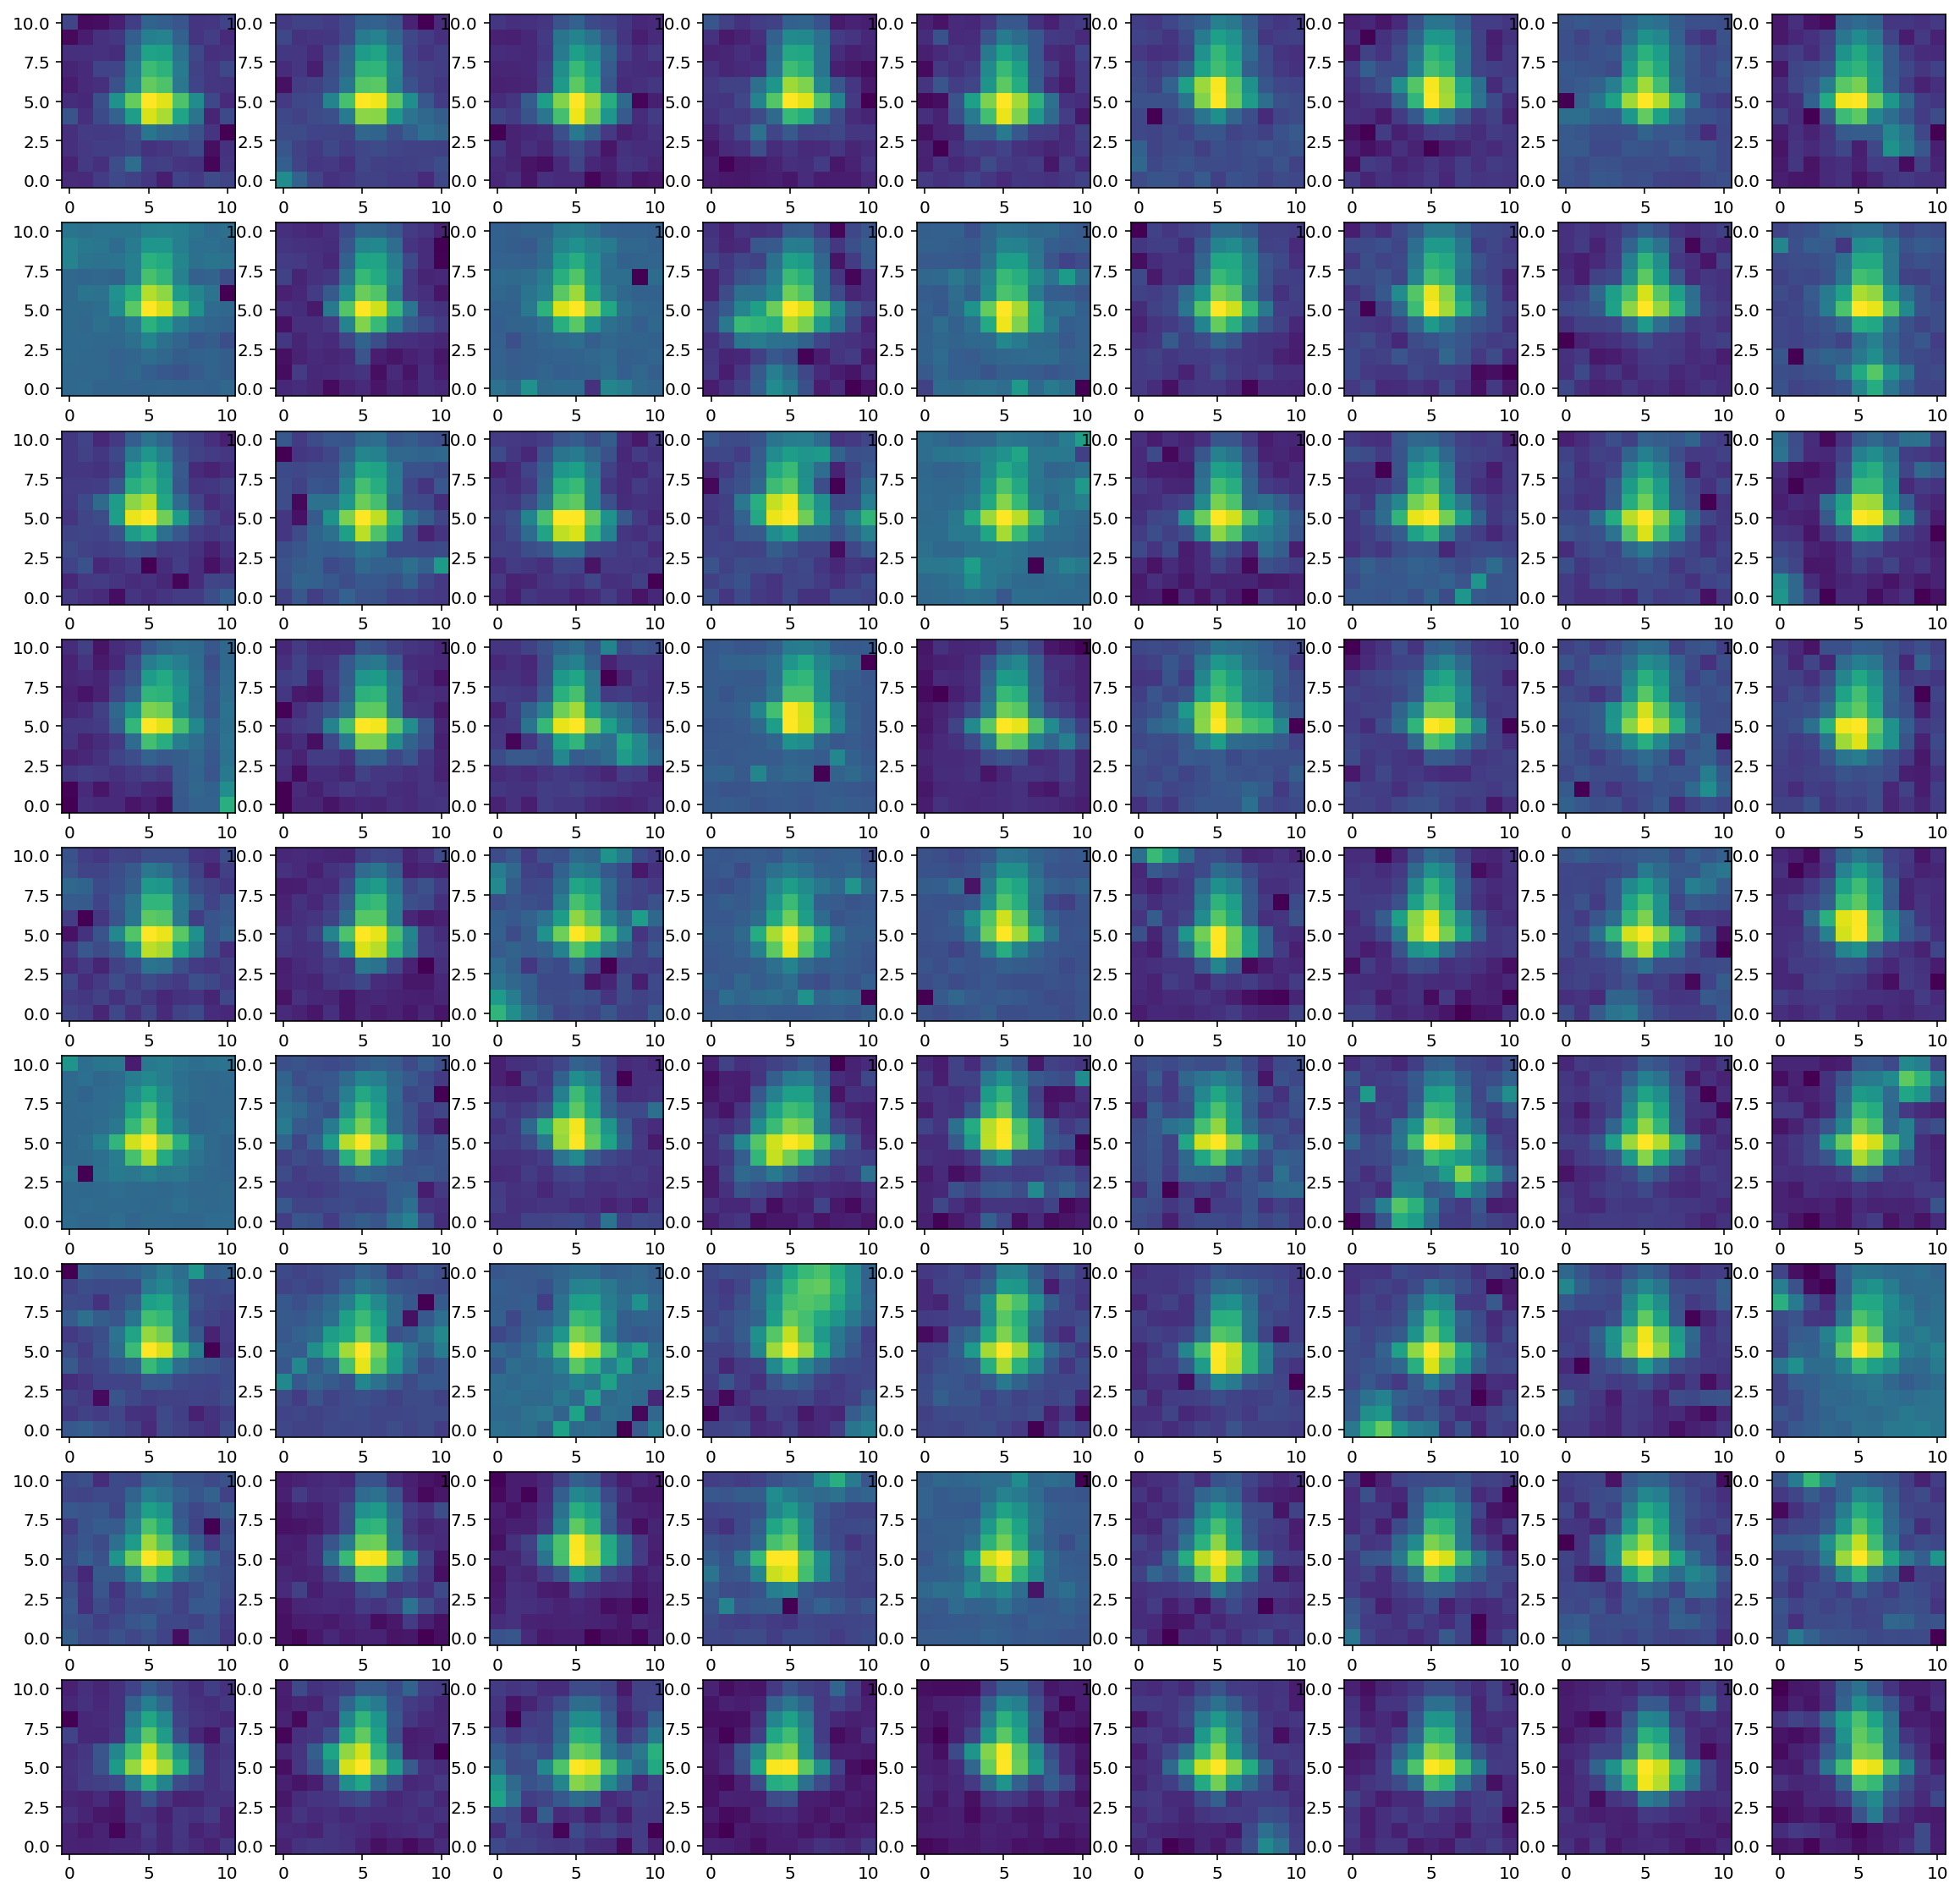

In [41]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 9
ncols = 9
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

With the star cutouts in hand, we are ready to construct the ePSF with
the :class:`~photutils.psf.EPSFBuilder` class.  We'll create an ePSF
with an oversampling factor of 4.0.  Here we limit the maximum number
of iterations to 3 (to limit it's run time), but in practice one
should use about 10 or more iterations.  The
:class:`~photutils.psf.EPSFBuilder` class has many other options to
control the ePSF build process, including changing the centering
function, the smoothing kernel, and the centering accuracy.  Please
see the :class:`~photutils.psf.EPSFBuilder` documentation for further
details.

We first initialize an :class:`~photutils.psf.EPSFBuilder` instance
with our desired parameters and then input the cutouts of our selected
stars to the instance:

In [42]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

The returned values are the ePSF, as an
:class:`~photutils.psf.EPSFModel` object, and our input stars fitted
with the constructed ePSF, as a new :class:`~photutils.psf.Stars`
object with fitted star positions and fluxes.

Finally, let's show the constructed ePSF:

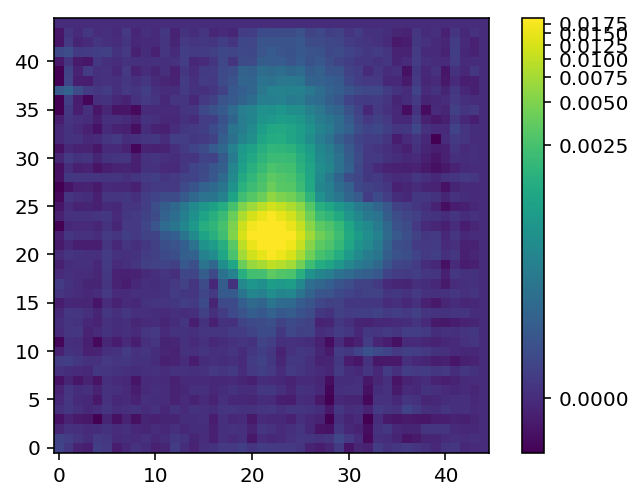

In [43]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [44]:
levels = np.nanpercentile(epsf.data, np.arange(93, 99.7, 0.2))

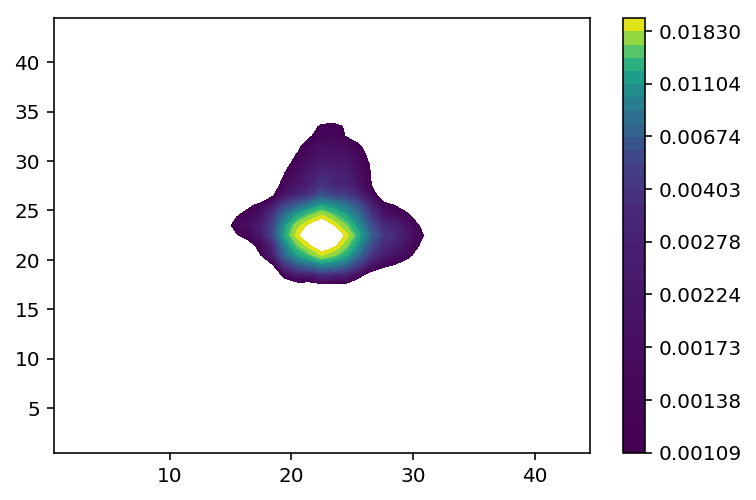

In [45]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'linear', percent=50.)
plt.contourf(epsf.data, levels=levels, origin='lower', cmap='viridis')
plt.colorbar()

The :class:`~photutils.psf.EPSFModel` object is a subclass of
:class:`~photutils.psf.FittableImageModel`, thus it can be used as a
the PSF model for the `PSF-fitting machinery in Photutils
<http://photutils.readthedocs.io/en/latest/psf.html>`_ (i.e.
`~photutils.psf.BasicPSFPhotometry`,
`~photutils.psf.IterativelySubtractedPSFPhotometry`, or
`~photutils.psf.DAOPhotPSFPhotometry`).

Neat...